# Homework 4: GAN and NAS

### Name: [Hongqi Guo]

## In this assignment, you will:

## (1) run and understand the provided pytorch code for GAN;
## (2) read a NAS paper and answer the questions.


## Submission:

* Convert the ipynb files to html files (**save the execution outputs and make sure the html file is generated properly**)
    
* Compress and submit the ipynb and html files to Blackboard. Remember to name your html file with your name and ID.
(When submitting: you will have one ipynb file and one html file for GAN section, and one ipynb file, i.e., this file, and one html file for the rest sections)

* **Deadline: May 5**, 11:59:59 PM, Pacific time.

* **Late policy**: your total points will be **$100 - \min( 10n, 80 )$** if you submit assignment $n$ days after the deadline.
(If you have any difficulty in time schedule, please let me know.)

* If you are more comfortable to use other libraries such as Keras and TensorFlow, you can change the code accordingly.

* You may use [Google Colab](https://colab.research.google.com/) to get free access to GPUs
(how to: Runtime --> Change runtime type --> Hardware accelerator --> GPU)

## Reference
* GAN section follows [Dive into Deep Learning](https://d2l.ai/index.html), section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html).


# 1. GAN

1) Please use the provided code in [Dive into Deep Learning](https://d2l.ai/index.html), section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html) deep convolutional generative adversarial networks .

2) Choose a library (MXNET or PYTORCH) on the page

3) Click "COLAB\[MXNET\]" or "COLAB\[PYTORCH\]" (see [this section](https://d2l.ai/chapter_installation/index.html) for the installation of the used libraries MXNET or PYTORCH if you need to install them). Or access these jupyter notebook directly at [MXNET](https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_generative-adversarial-networks/dcgan.ipynb) or [PYTORCH](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_generative-adversarial-networks/dcgan.ipynb)

4) (30 points) Run all code for training a GAN on the pokemon dataset with Colab and save the  execution outputs

5) (30 points) Complete exercises 1 in [Section 17.2.6](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html#exercises): what if use standard ReLU activation rather than leaky ReLU.
You may add your code at the end of the ipynb file.

Hint for pytorch: 
Generator uses ReLU as the activation function, so you may follow the generator's code to replace leakyReLU with ReLU in discriminator.
You may also find the document of [torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) and [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) to see the full description of the interfaces.

6) Download the GAN ipynb file and convert it to html format.

In [1]:
!pip install torch torchvision
# -U: Upgrade all packages to the newest available version
!pip install -U d2l

Requirement already up-to-date: d2l in c:\users\hongq\anaconda3\lib\site-packages (0.16.3)


In [2]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


In [3]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [4]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size, shuffle=True,
    num_workers=d2l.get_dataloader_workers())

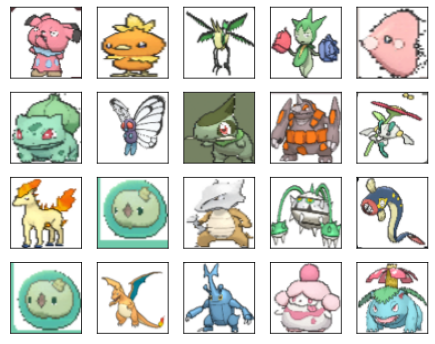

In [5]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [6]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                               kernel_size, strides, padding,
                                               bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

In [8]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

In [9]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G * 8, strides=1,
            padding=0),  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G * 8,
            out_channels=n_G * 4),  # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G * 4,
            out_channels=n_G * 2),  # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G * 2, out_channels=n_G),  # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

In [10]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

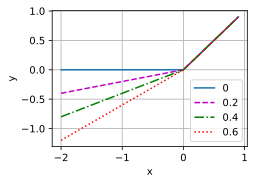

In [11]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

In [12]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [13]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [14]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D,
            out_channels=n_D * 2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D * 2,
            out_channels=n_D * 4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D * 4,
            out_channels=n_D * 8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D * 8, out_channels=1, kernel_size=4,
              bias=False))  # Output: (1, 1, 1)

In [15]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [16]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat([
            torch.cat([fake_x[i * 7 + j].cpu().detach()
                       for j in range(7)], dim=1)
            for i in range(len(fake_x) // 7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.056, loss_G 7.142, 16.3 examples/sec on cuda:0


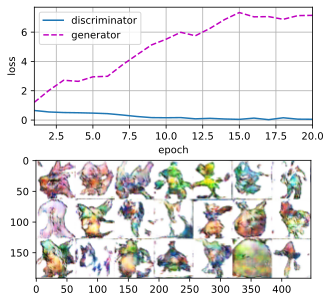

In [17]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [ ]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size, shuffle=True,
    num_workers=d2l.get_dataloader_workers())

warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break
    
    
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                               kernel_size, strides, padding,
                                               bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))
    
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G * 8, strides=1,
            padding=0),  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G * 8,
            out_channels=n_G * 4),  # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G * 4,
            out_channels=n_G * 2),  # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G * 2, out_channels=n_G),  # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

 alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.ReLU(alpha)(x).detach().numpy() for alpha in alphas]

d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))
    
    
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D,
            out_channels=n_D * 2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D * 2,
            out_channels=n_D * 4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D * 4,
            out_channels=n_D * 8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D * 8, out_channels=1, kernel_size=4,
              bias=False))  # Output: (1, 1, 1)

x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat([
            torch.cat([fake_x[i * 7 + j].cpu().detach()
                       for j in range(7)], dim=1)
            for i in range(len(fake_x) // 7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')
    
    
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)



# 2. NAS

Read reference paper \[1\] (at [this link](https://arxiv.org/pdf/1707.04873.pdf)) on NAS. and Answer the following two questions (use plain lanugage to describe your answer and no need to include too many techniques)

Hint: you may not read the entire paper. Instead, read the first paragraph of subsection "Net2Deeper Actor" on Page 3 (You may search the key word "Net2Deeper Actor" on the pdf file to find the subsection on page 3). To get better understanding towards Net2Deeper Actor, you may also read the subsection "Net2Wider Actor" on Page 3.

Q1 (20 points): How to initialize the kernel of a new convolutional layer in the Net2Deeper actor?

**Answer:For the new convolutional layer, set the kernel as an identity filter.The recurrent network is used to determine the position of the new layer in sequence, and the corresponding parameters of the new layer are determined according to the final hidden layer state of the encoder network based on the given input structure.**

Q2 (20 points): How could we widen this new convolutional layer?

**Answer:Net2Wider Actor.Replace one layer with a wider layer, which will preserve functionality and expand space.**

Reference:

\[1\] Cai, Han, Tianyao Chen, Weinan Zhang, Yong Yu, and Jun Wang. "Efficient architecture search by network transformation." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 32, no. 1. 2018.